In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import gurobi_logtools as glt

In [2]:
theta_list = [5e-1, 1e-1]  # the Wasserstein radius. 
epsilon_list = [0.05, 0.025]  # [0.05, 0.025] the risk level
gurobi_seed_list = [i for i in range(0, 10000*150, 10000)] 
num_gen_list = [100]  # the number of thermal generators
N_WDR_list = [50, 100, 150]  # the number of scenarios for the WDRJCC
load_scaling_factor_list = [1]  # [1] the scaling factor for the load
T_list = [8, 12, 16, 20, 24, 28]
network_name = 'case24_ieee_rts' 
Fgap = 0.001 # 0.1%, the same as the MIP gap
quadra_cost = True
bigM = 1e5
thread=4
timelimit = 3600

In [3]:
# reload the module to have updated functions
from importlib import reload
import SUC_all_param_eval
reload(SUC_all_param_eval)

param_comb = list(itertools.product(load_scaling_factor_list, epsilon_list, theta_list, T_list, num_gen_list, N_WDR_list))

save_path_root = os.path.join(os.getcwd(), f'SUC_results_bigM{int(bigM)}_thread{thread}')

def convert(n):
    # return the original number if it is not None nor nan, otherwise return nan
    if (n is None) or (np.isnan(n)):
        return np.nan
    else:
        return n

def n_nonan(n):
    # return the number of non-nan in the list
    return sum([1 for i in n if not np.isnan(i)])

def mynanmean(n):
    # if all nan, return nan; otherwise, return the nanmean
    return np.nan if all(np.isnan(i) for i in n) else np.nanmean(n)

def sortedmean(n, first_k):
    return mynanmean(np.sort(n)[:first_k])

def retrieve_log(log_save_path, nan_flag, Fgap, obj2compare, status):
    if not nan_flag:
        if np.isnan(obj2compare):
            obj2compare = 1e9 # any feasible solution is eligible
        # the model needs to be feasible
        log = glt.parse(log_save_path).progress()
        # the first time when a feasible solution comparable to the obj2compare is found
        # find rows with incumbent similar to the obj2compare
        log_selected = log[((log['Incumbent'] - obj2compare)/np.abs(obj2compare)) <= Fgap]
        
        if len(log_selected) == 0:
            # no solution with quality similar to the proposed best solution
            time_F = timelimit # set to timelimit as explained in the paper
            min_cost_F = log.iloc[-1]['Incumbent']
        else:
            index = log_selected.index[0] # find the first index
            time_F = log.loc[index, 'Time']
            min_cost_F = log.loc[index, 'Incumbent']

    else:
        # model is infeasible or no feasible solution found. As will be validated next, there is no infeasible runs for the proposed method (SFLA) as well as the exact method (ExactS) 
        time_F = timelimit if status.item() == 'TIME_LIMIT' else np.nan
        min_cost_F = np.nan
    return time_F, min_cost_F

def load_results(param_comb, save_path_root):
    # save the average result
    res_df = []
    # save the result for each random run
    res_all_df = []
    for param in param_comb:
        # load the parameters. N_WDR is the number of historical samples of random variables for the WDRJCC
        load_scaling_factor, epsilon, theta, T, num_gen, N_WDR = param
        # note, all time results are in seconds
        min_cost_proposed_list = [] # cost of the optimal solution found by the proposed method
        min_cost_proposed_F_list = [] # cost of the high-quality solution found by the proposed method
        reliability_proposed_list = [] # out-of-sample reliability of the proposed method
        time_proposed_list = [] # time for the proposed method to find the optimal solution
        time_proposed_F_list = [] # time for the proposed method to find the first high-quality solution
        
        min_cost_exact_F_list = []
        min_cost_exact_list = []
        min_cost_exact_prop_diff_list = []
        reliability_exact_list = []
        time_exact_list = []
        time_exact_F_list = []
        break_flag = False
        
        for gurobi_seed in gurobi_seed_list:
            # the path to the result
            res_save_path_proposed = os.path.join(save_path_root, f'result_{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_proposed_T{T}{"quadra_cost" if quadra_cost else ""}.npy')
            log_save_path_proposed = os.path.join(save_path_root, f'{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_proposed_T{T}{"quadra_cost" if quadra_cost else ""}.txt')
            res_save_path_exact = os.path.join(save_path_root, f'result_{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_exact_T{T}{"quadra_cost" if quadra_cost else ""}.npy')
            log_save_path_exact = os.path.join(save_path_root, f'{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_exact_T{T}{"quadra_cost" if quadra_cost else ""}.txt')
            
            # the following IF statement enables you to see the results over the running process (no need to wait until the end of the whole process)
            if not os.path.exists(res_save_path_proposed) or not os.path.exists(res_save_path_exact):
                break_flag = True
                break
            
            res_proposed = np.load(res_save_path_proposed, allow_pickle=True).item()
            res_exact = np.load(res_save_path_exact, allow_pickle=True).item()
            proposed_status = glt.parse(log_save_path_proposed).summary().Status # the optimization status of the proposed method
            exact_status = glt.parse(log_save_path_exact).summary().Status
            
            min_cost_proposed = res_proposed['min_cost (USD)']
            reliability_proposed = res_proposed['reliability_test (%)']
            time_proposed = res_proposed['t_solve (s)']
            
            if np.isnan(convert(time_proposed)) and (proposed_status.item() == 'TIME_LIMIT'):
                # As explained in the paper, we set the time to the timelimit if no feasible solution is found
                # note that there is no infeasible runs for the proposed method (SFLA) as well as the exact method (ExactS)
                time_proposed = timelimit
            
            min_cost_exact = res_exact['min_cost (USD)']
            reliability_exact = res_exact['reliability_test (%)']
            time_exact = res_exact['t_solve (s)']
            if np.isnan(convert(time_exact)) and (exact_status.item() == 'TIME_LIMIT'):
                # As explained in the paper, we set the time to the timelimit if no feasible solution is found
                # note that there is no infeasible runs for the proposed method (SFLA) as well as the exact method (ExactS)
                time_exact = timelimit
            
            # load the information associated with the first high-quality solution
            time_exact_F, min_cost_exact_F = (
                retrieve_log(log_save_path=log_save_path_exact, nan_flag=np.isnan(min_cost_exact), Fgap=Fgap, obj2compare=min_cost_proposed, status=exact_status))
            
            time_proposed_F, min_cost_proposed_F = (
                retrieve_log(log_save_path=log_save_path_proposed, nan_flag=np.isnan(min_cost_proposed), Fgap=Fgap, obj2compare=min_cost_proposed, status=proposed_status))
            
            # append results to lists
            min_cost_proposed_list.append(convert(min_cost_proposed))
            min_cost_proposed_F_list.append(convert(min_cost_proposed_F))
            reliability_proposed_list.append(convert(reliability_proposed))
            time_proposed_list.append(convert(time_proposed))
            time_proposed_F_list.append(convert(time_proposed_F))
            time_exact_F_list.append(convert(time_exact_F))
            min_cost_exact_F_list.append(convert(min_cost_exact_F))
            min_cost_exact_list.append(convert(min_cost_exact))
            reliability_exact_list.append(convert(reliability_exact))
            time_exact_list.append(convert(time_exact))
            # the difference between the exact and proposed optimal solutions. Only consider the cases where both are optimal, as explained in the paper.
            min_cost_exact_prop_diff_list.append(convert((min_cost_proposed - min_cost_exact_F)/min_cost_proposed) if (proposed_status.item()=='OPTIMAL') and (exact_status.item()=='OPTIMAL') else np.nan)
            
            res_all_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta, 
                'T': T,
                'num_gen': num_gen, 
                'N_WDR': N_WDR, 
                'proposed time F': time_proposed_F_list[-1],
                'exact time F': time_exact_F_list[-1], 
                'proposed time': time_proposed_list[-1], 
                'exact time': time_exact_list[-1],
                'proposed obj F': min_cost_proposed_F_list[-1],
                'exact obj F': min_cost_exact_F_list[-1], 
                'proposed obj': min_cost_proposed_list[-1], 
                'exact obj': min_cost_exact_list[-1], 
                'exact prop diff (%)': min_cost_exact_prop_diff_list[-1]*100, 
                'proposed reli': reliability_proposed_list[-1],
                'exact reli': reliability_exact_list[-1],
                'proposed status': proposed_status,
                'exact status': exact_status,
                'seed': gurobi_seed
            }, index=[0]))
        
        if not break_flag:
            # append to df
            res_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta, 
                'T': T,
                'num_gen': num_gen, 
                'N_WDR': N_WDR, 
                'proposed time F': mynanmean(time_proposed_F_list),
                'exact time F': mynanmean(time_exact_F_list), 
                'proposed time': mynanmean(time_proposed_list), 
                'exact time': mynanmean(time_exact_list),
                'proposed obj F': mynanmean(min_cost_proposed_F_list),
                'exact obj F': mynanmean(min_cost_exact_F_list), 
                'proposed obj': mynanmean(min_cost_proposed_list), 
                'exact obj': mynanmean(min_cost_exact_list), 
                'exact prop diff (%)': mynanmean(min_cost_exact_prop_diff_list)*100, 
                'proposed reli': mynanmean(reliability_proposed_list),
                'exact reli': mynanmean(reliability_exact_list),
            }, index=[0]))
            
    res_df = pd.concat(res_df, ignore_index=True)
    res_all_df = pd.concat(res_all_df, ignore_index=True)
    return res_df, res_all_df

res_df, res_all_df = load_results(param_comb, save_path_root)
# save the table to communicate the results to other collaborators
path_name = os.path.join(os.path.dirname(save_path_root), f'result_{network_name}{"quadra_cost" if quadra_cost else ""}.csv')   
res_df.to_csv(path_name, index=False)
res_df

,eps,theta,T,num_gen,N_WDR,proposed time F,exact time F,proposed time,exact time,proposed obj F,exact obj F,proposed obj,exact obj,exact prop diff (%),proposed reli,exact reli
0,0.050,0.5,8,100,100,1.773333,8.193333,2.429916,9.118986,217000.099639,216994.315100,216983.404711,216984.856549,-0.004548,99.892533,99.894400
1,0.050,0.5,12,100,100,13.306667,33.373333,59.059150,58.222813,324476.065270,324447.299996,324455.422576,324435.719952,-0.002403,99.833333,99.834133
2,0.050,0.5,16,100,100,26.806667,78.586667,194.461010,129.013021,431138.252268,430966.578238,431117.848727,430958.628514,0.003478,99.762133,99.767785
3,0.050,0.5,20,100,100,109.740000,107.086667,380.320875,186.012205,533610.981559,533218.912247,533565.279262,533175.174308,-0.004547,99.721781,99.720135
4,0.050,0.5,24,100,50,118.173333,643.186667,376.248246,812.621190,626197.279180,630766.486199,626129.742596,628200.514318,-0.010009,99.138082,99.202313
5,0.050,0.5,24,100,100,88.040000,343.206667,512.401418,473.422880,632419.242557,631621.548027,632392.849428,631591.384991,0.000650,99.672432,99.676735
6,0.050,0.5,24,100,150,73.820000,208.253333,471.250139,288.921176,635376.170376,633624.478588,635355.738551,633596.323202,-0.004224,99.801081,99.803129
7,0.050,0.5,28,100,100,175.206667,477.100000,842.250543,796.121161,745274.254639,742337.794600,745202.563756,742316.577180,-0.005699,99.593194,99.593194
8,0.050,0.1,8,100,100,1.853333,1.826667,2.462480,35.060038,209569.889490,209378.829432,209564.955462,209147.539881,0.087978,95.725867,95.406267
9,0.050,0.1,12,100,100,15.026667,78.420000,64.623873,176.981599,313486.753904,313289.509081,313468.697001,313024.454374,0.058718,93.641200,93.607114


In [4]:
# show the number of statuses
print(f'the unique statuses in proposed: {res_all_df["proposed status"].unique()}')
print(f'the unique statuses in exact: {res_all_df["exact status"].unique()}')
# if there are statuses other than optimal and time limit, raise an error
if not all(i in ['OPTIMAL', 'TIME_LIMIT'] for i in res_all_df['proposed status'].unique()):
    raise ValueError('There are statuses other than OPTIMAL and TIME_LIMIT in proposed')
if not all(i in ['OPTIMAL', 'TIME_LIMIT'] for i in res_all_df['exact status'].unique()):
    raise ValueError('There are statuses other than OPTIMAL and TIME_LIMIT in exact')

# the proportion of Time Limit in proposed
print(f'the proportion of Time Limit in proposed: {sum(res_all_df["proposed status"]=="TIME_LIMIT")/len(res_all_df)}')
# the proportion of Time Limit in exact
print(f'the proportion of Time Limit in exact: {sum(res_all_df["exact status"]=="TIME_LIMIT")/len(res_all_df)}')
# res_all_df

the unique statuses in proposed: ['OPTIMAL' 'TIME_LIMIT']
the unique statuses in exact: ['OPTIMAL' 'TIME_LIMIT']
the proportion of Time Limit in proposed: 0.08458333333333333
the proportion of Time Limit in exact: 0.13270833333333334


We can see that the proportion of "Time Limit" runs of "proposed" (the proposed SFLA) is lower than "exact" (ExactS), which demonstrates the efficiency of the proposed method.

# Plotting the results

In [5]:
# configure the plotting
import seaborn as sns
import matplotlib.pyplot as plt
# set plotting options, font size, and style to Academic theme (Times New Roman, etc.)
# Set matplotlib style
plt.style.use('default')
plt.rcParams.update({
    'font.size': 14,
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'legend.fontsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
    "mathtext.fontset": "cm",
})

# Plot the proposed time vs exact time F

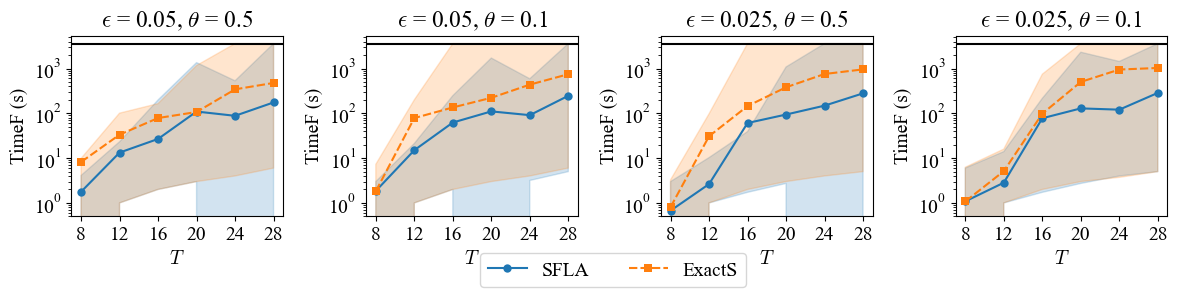

In [6]:
# the x-axis is the T
def to_plot(df):
    # convert the raw df to the format that can be plotted
    df = df.reset_index()
    method_list = ['proposed', 'exact']
    method2dict = {'proposed': 'SFLA', 'exact': 'ExactS'}
    df_plot = []
    for i in range(len(df)):
        for method in method_list:
            df_plot.append(pd.DataFrame({
                'seed': df.loc[i, 'seed'],
                'eps': df.loc[i, 'eps'], 
                'theta': df.loc[i, 'theta'], 
                'num_gen': df.loc[i, 'num_gen'], 
                'T': df.loc[i, 'T'],
                'N_WDR': df.loc[i, 'N_WDR'], 
                'time F': df.loc[i, f'{method} time F'], 
                'time': df.loc[i, f'{method} time'],
                'obj F': df.loc[i, f'{method} obj F'],
                'obj': df.loc[i, f'{method} obj'],
                'method': method2dict[method]
            }, index=[0]))
            
    df_plot = pd.concat(df_plot, ignore_index=True)
    return df_plot

num_gen = 100 
N_WDR = 100
epsilon_list_plot = epsilon_list
theta_list_plot = theta_list
T_list_plot = [8, 12, 16, 20, 24, 28]
markers = ['o', 's']  # Different markers for each line
TimeF = True

num_seed = 150
seed_threshold = gurobi_seed_list[:num_seed][-1]+1 # +1 to include the last seed (avoid numerical error)

fig, axs = plt.subplots(1, len(epsilon_list_plot)*len(theta_list_plot), figsize=(3*len(epsilon_list_plot)*len(theta_list_plot), 3))
for i, eps in enumerate(epsilon_list_plot):
    for j, theta in enumerate(theta_list_plot):
        res_all_df_plot = to_plot(res_all_df[(res_all_df['eps'] == eps) & (res_all_df['theta'] == theta) & (res_all_df['num_gen'] == num_gen)  & (res_all_df['N_WDR'] == N_WDR) & (res_all_df['seed']<=seed_threshold) & (res_all_df['T'].isin(T_list_plot))].copy())
        ax = axs[i*2+j]
        sns.lineplot(x='T', y='time F' if TimeF else 'time', data=res_all_df_plot, ax=ax, 
             hue='method', estimator='mean', errorbar=('pi', 95), style='method', markers=markers, n_boot=1000, markersize=6, markeredgewidth=0)
        # plot a horizontal line at timelimit
        ax.axhline(timelimit, color='black', linestyle='-')
        ax.set_title(fr'$\epsilon$ = {eps}, $\theta$ = {theta}')
        # set xticks
        ax.set_xticks(T_list_plot)
        # set x axis
        ax.set_xlabel('$T$')
        ax.set_ylabel('TimeF (s)' if TimeF else 'Time (s)')
        # log y scale
        ax.set_yscale('log')
        # set ylim
        ax.set_ylim(.5, timelimit*1.5)
        # do not display the legend
        ax.get_legend().remove()
    
# create my own legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, .15), ncol=2)
plt.tight_layout()
# plt.subplots_adjust(top=0.87)
# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'suc_time_{network_name}{"quadra_cost" if quadra_cost else ""}_Fgap{Fgap}_allT_N{N_WDR}.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)

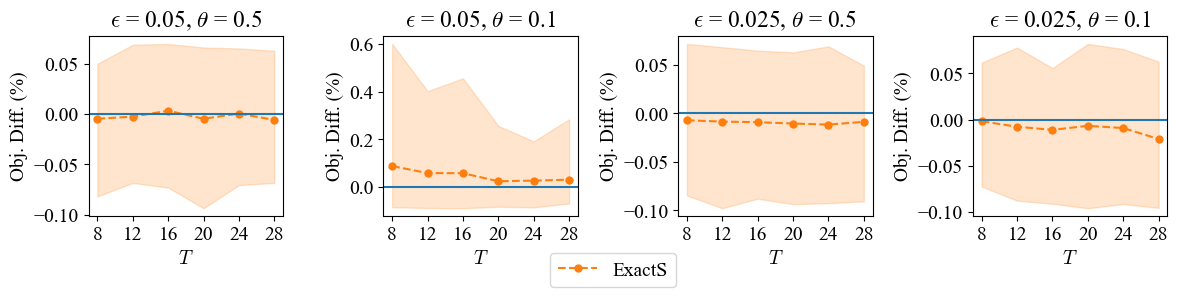

In [7]:
# the x-axis is the T
def to_plot(df):
    df = df.reset_index()
    df_plot = []
    for i in range(len(df)):
        df_plot.append(pd.DataFrame({
            'seed': df.loc[i, 'seed'],
            'eps': df.loc[i, 'eps'], 
            'theta': df.loc[i, 'theta'], 
            'num_gen': df.loc[i, 'num_gen'], 
            'T': df.loc[i, 'T'],
            'N_WDR': df.loc[i, 'N_WDR'], 
            'Obj. Diff. (%)': df.loc[i, 'exact prop diff (%)'], 
        }, index=[0]))

    df_plot = pd.concat(df_plot, ignore_index=True)
    return df_plot


# the second color of tab:10
color = sns.color_palette("tab10")[1]

num_gen = 100 
N_WDR = 100
epsilon_list_plot = epsilon_list
theta_list_plot = theta_list
T_list_plot = [8, 12, 16, 20, 24, 28]
markers = ['o', 's']  # Different markers for each line
TimeF = True

num_seed = 150
seed_threshold = gurobi_seed_list[:num_seed][-1]+1

fig, axs = plt.subplots(1, len(epsilon_list_plot)*len(theta_list_plot), figsize=(3*len(epsilon_list_plot)*len(theta_list_plot), 3))

for i, eps in enumerate(epsilon_list_plot):
    for j, theta in enumerate(theta_list_plot):
        res_all_df_plot = to_plot(res_all_df[(res_all_df['eps'] == eps) & (res_all_df['theta'] == theta) & (res_all_df['num_gen'] == num_gen)  & (res_all_df['N_WDR'] == N_WDR) & (res_all_df['seed']<=seed_threshold) & (res_all_df['T'].isin(T_list_plot))].copy())
        ax = axs[i*2+j]
        sns.lineplot(x='T', y='Obj. Diff. (%)' if TimeF else 'time', data=res_all_df_plot, ax=ax, 
             estimator='mean', errorbar=('pi', 95), markers=markers, n_boot=1000, markersize=6, markeredgewidth=0, color=color, marker = 'o', linestyle='--')
        ax.axhline(0, color=sns.color_palette("tab10")[0], linestyle='-')

        ax.set_title(fr'$\epsilon$ = {eps}, $\theta$ = {theta}')
        # set xticks
        ax.set_xticks(T_list_plot)
        # set x axis
        ax.set_xlabel('$T$')
        ax.set_ylabel('Obj. Diff. (%)')

# create my own legend for ExactS
custom_lines = [plt.Line2D([0], [0], color=color, marker='o', linestyle='--', markersize=6, markeredgewidth=0)]
fig.legend(custom_lines, ['ExactS'], loc='upper center', bbox_to_anchor=(0.52, .15), ncol=2)
plt.tight_layout()
# plt.subplots_adjust(top=0.87)
# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'suc_gap_{network_name}{"quadra_cost" if quadra_cost else ""}_Fgap{Fgap}_allT_N{N_WDR}.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)

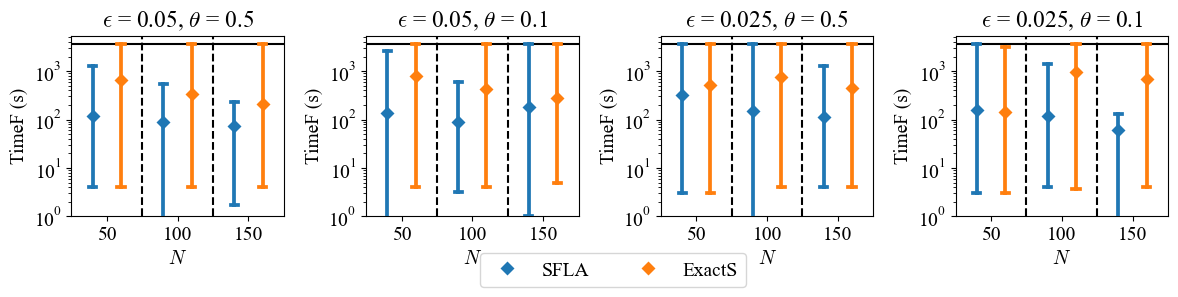

In [8]:
def to_plot(df):
    df = df.reset_index()
    method_list = ['proposed', 'exact']
    method2dict = {'proposed': 'SFLA', 'exact': 'ExactS'}
    df_plot = []
    for i in range(len(df)):
        for method in method_list:
            df_plot.append(pd.DataFrame({
                'eps': df.loc[i, 'eps'], 
                'theta': df.loc[i, 'theta'], 
                'num_gen': df.loc[i, 'num_gen'], 
                'N_WDR': df.loc[i, 'N_WDR'], 
                'time F': df.loc[i, f'{method} time F'], 
                'time': df.loc[i, f'{method} time'],
                'obj F': df.loc[i, f'{method} obj F'],
                'obj': df.loc[i, f'{method} obj'],
                'method': method2dict[method]
            }, index=[0]))

    df_plot = pd.concat(df_plot, ignore_index=True)
    return df_plot

num_gen = 100 
T=24
N_WDR_list_plot = [50, 100, 150]
epsilon_list_plot = epsilon_list
theta_list_plot = theta_list
num_seed = 150
seed_threshold = gurobi_seed_list[:num_seed][-1]+1

fig, axs = plt.subplots(1, len(epsilon_list_plot)*len(theta_list_plot), figsize=(3*len(epsilon_list_plot)*len(theta_list_plot), 3))
for i, eps in enumerate(epsilon_list_plot):
    for j, theta in enumerate(theta_list_plot):
        res_all_df_plot = to_plot(res_all_df[(res_all_df['eps'] == eps) & (res_all_df['theta'] == theta) & (res_all_df['num_gen'] == num_gen) & (res_all_df['seed']<=seed_threshold) & (res_all_df['T'] == T) & (res_all_df['N_WDR'].isin(N_WDR_list_plot))].copy())
        ax = axs[i*2+j]
        ax.set_title(fr'$\epsilon$ = {eps}, $\theta$ = {theta}')
        sns.pointplot(x='N_WDR', y='time F', data=res_all_df_plot, ax=ax, 
             hue='method', dodge=.4, estimator='mean', markers=['D', 'D', 'D', 'D'], linestyle='none', errorbar=('pi', 95), zorder=10, capsize = .1, markersize=5)
        for line_i in range(0, len(res_all_df_plot['N_WDR'].unique())-1):
            ax.axvline(line_i+.5, color='black', linestyle='--')

        # plot a black horizontal line at timelimit
        ax.axhline(timelimit, color='black', linestyle='-')
        # set x axis
        ax.set_xlabel('$N$')
        ax.set_ylabel('TimeF (s)')
        # log y scale
        ax.set_yscale('log')
        # set ylim
        ax.set_ylim(1, timelimit*1.5)
        # do not display the legend
        ax.get_legend().remove()

# create my own legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.52, .15), ncol=2)
plt.tight_layout()
# plt.subplots_adjust(top=0.87)
# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'suc_time_{network_name}_T{T}{"quadra_cost" if quadra_cost else ""}_Fgap{Fgap}.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)

# Plot the difference of the final optimality

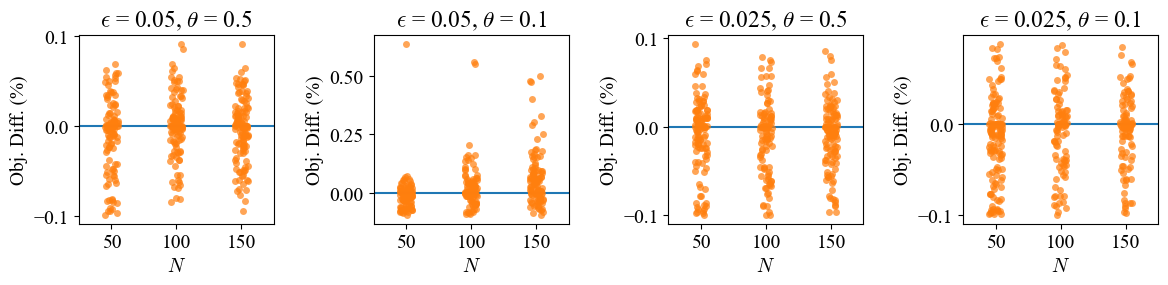

In [9]:
def to_plot_gap(df):
    df = df.reset_index()
    df_plot = []
    for i in range(len(df)):
        df_plot.append(pd.DataFrame({
            'T': df.loc[i, 'T'],
            'eps': df.loc[i, 'eps'], 
            'theta': df.loc[i, 'theta'], 
            'num_gen': df.loc[i, 'num_gen'], 
            'N_WDR': df.loc[i, 'N_WDR'], 
            'Obj. Diff. (%)': df.loc[i, 'exact prop diff (%)'], 
        }, index=[0]))
            
    df_plot = pd.concat(df_plot, ignore_index=True)
    return df_plot

num_gen = 100 
T=24

N_WDR_list_plot = [50, 100, 150]
epsilon_list_plot = epsilon_list
theta_list_plot = theta_list
num_seed = 150
seed_threshold = gurobi_seed_list[:num_seed][-1]+1

# the second color of tab:10
color = sns.color_palette("tab10")[1]

fig, axs = plt.subplots(1, len(epsilon_list_plot)*len(theta_list_plot), figsize=(3*len(epsilon_list_plot)*len(theta_list_plot), 3))
# Plot each subplot
for i, eps in enumerate(epsilon_list_plot):
    for j, theta in enumerate(theta_list_plot):
        # Filter and prepare the data
        res_all_df_plot = to_plot_gap(res_all_df[(res_all_df['eps'] == eps) & 
                                                 (res_all_df['theta'] == theta) & 
                                                 (res_all_df['num_gen'] == num_gen) & 
                                                 (res_all_df['seed']<=seed_threshold) & 
                                                 (res_all_df['T'] == T) & 
                                                 (res_all_df['N_WDR'].isin(N_WDR_list_plot))].copy())
        
        ax = axs[i*2+j]
        
        # Strip plot: showing the distribution of data points
        sns.stripplot(x='N_WDR', y='Obj. Diff. (%)', data=res_all_df_plot, ax=ax, dodge=True, legend=False, marker='o', alpha=0.7, color=color, jitter=True)
        
        # make a horizontal line at 0
        ax.axhline(0, color=sns.color_palette("tab10")[0], linestyle='-')
        # Set the title for the subplot
        ax.set_title(fr'$\epsilon$ = {eps}, $\theta$ = {theta}')
        
        # Set x-axis label
        ax.set_xlabel('$N$')
    
        
plt.tight_layout()
plt.subplots_adjust(top=0.87)
# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'suc_gap_{network_name}_T{T}{"quadra_cost" if quadra_cost else ""}.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)

In [10]:
# process the table to generate LateX code
res_df_display = res_df.copy()
N_WDR_list_plot = [50, 100, 150]
res_df_display = res_df_display[res_df_display['N_WDR'].isin(N_WDR_list_plot)]

res_df_display = res_df_display[res_df_display['T'] == 24]
res_df_display = res_df_display[['eps', 'theta', 'N_WDR', 'proposed time F', 'exact time F', 'exact prop diff (%)', 'proposed time', 'exact time', 'proposed reli', 'exact reli']]
res_df_display = res_df_display.rename(columns={
    'eps': r'$\epsilon$', 
    'theta': r'$\theta$', 
    'N_WDR': '$N$', 
    'proposed time F': 'SFLA Time F (s)', 
    'exact time F': 'ExactS Time F (s)', 
    'proposed time': 'SFLA Time (s)',
    'exact time': 'ExactS Time (s)',
    'exact prop diff (%)': r'Obj. Diff. (\%)',
    'proposed reli': 'SFLA Reli. (\%)',
    'exact reli': 'ExactS Reli. (\%)'
})

# round time to 2 decimal places
res_df_display['SFLA Time F (s)'] = res_df_display['SFLA Time F (s)'].round(2)
res_df_display['ExactS Time F (s)'] = res_df_display['ExactS Time F (s)'].round(2)
res_df_display['SFLA Time (s)'] = res_df_display['SFLA Time (s)'].round(2)
res_df_display['ExactS Time (s)'] = res_df_display['ExactS Time (s)']
# round gap to 3 decimal places
res_df_display[r'Obj. Diff. (\%)'] = res_df_display[r'Obj. Diff. (\%)'].apply(lambda x: f'{x:.3f}' if not np.isnan(x) else x)
# round reli to 2 decimal places
res_df_display['SFLA Reli. (\%)'] = res_df_display['SFLA Reli. (\%)'].apply(lambda x: f'{x:.2f}' if not np.isnan(x) else x)
res_df_display['ExactS Reli. (\%)'] = res_df_display['ExactS Reli. (\%)'].apply(lambda x: f'{x:.2f}' if not np.isnan(x) else x)

# enumerate exact time F and display (in the patenthesis after the time) the speedup ratio to the proposed time F
res_df_display['ExactS Time F (s)'] = res_df_display.apply(lambda x: rf"{x['ExactS Time F (s)']:.2f}\ ({x['ExactS Time F (s)']/x['SFLA Time F (s)']:.2f}\times)", axis=1)
# enumerate exact time and display (in the patenthesis after the time) the speedup ratio to the proposed time
res_df_display['ExactS Time (s)'] = res_df_display.apply(lambda x: rf"{x['ExactS Time (s)']:.2f}\ ({x['ExactS Time (s)']/x['SFLA Time (s)']:.2f}\times)", axis=1)
# make all elements to be within $$
res_df_display = res_df_display.applymap(lambda x: rf'${x}$' if isinstance(x, (int, float, str)) else x)

# convert all number to string
res_df_display = res_df_display.map(lambda x: f'{x}' if isinstance(x, (int, float)) else x)
# # save the table
# path_name = os.path.join(os.path.dirname(save_path_root), f'result_{network_name}_T{T}{"quadra_cost" if quadra_cost else ""}_display.csv')
# res_df_display.to_csv(path_name, index=False)
res_df_display

/tmp/ipykernel_7334/3029844111.py:37: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  res_df_display = res_df_display.applymap(lambda x: rf'${x}$' if isinstance(x, (int, float, str)) else x)


,$\epsilon$,$\theta$,$N$,SFLA Time F (s),ExactS Time F (s),Obj. Diff. (\%),SFLA Time (s),ExactS Time (s),SFLA Reli. (\%),ExactS Reli. (\%)
4,$0.05$,$0.5$,$50$,$118.17$,$643.19\ (5.44\times)$,$-0.010$,$376.25$,$812.62\ (2.16\times)$,$99.14$,$99.20$
5,$0.05$,$0.5$,$100$,$88.04$,$343.21\ (3.90\times)$,$0.001$,$512.4$,$473.42\ (0.92\times)$,$99.67$,$99.68$
6,$0.05$,$0.5$,$150$,$73.82$,$208.25\ (2.82\times)$,$-0.004$,$471.25$,$288.92\ (0.61\times)$,$99.80$,$99.80$
12,$0.05$,$0.1$,$50$,$135.24$,$776.37\ (5.74\times)$,$-0.008$,$576.6$,$1098.01\ (1.90\times)$,$76.01$,$76.88$
13,$0.05$,$0.1$,$100$,$91.07$,$437.21\ (4.80\times)$,$0.027$,$521.25$,$1064.36\ (2.04\times)$,$88.03$,$88.51$
14,$0.05$,$0.1$,$150$,$185.28$,$273.93\ (1.48\times)$,$0.061$,$451.55$,$834.81\ (1.85\times)$,$91.87$,$92.14$
20,$0.025$,$0.5$,$50$,$326.1$,$525.47\ (1.61\times)$,$-0.008$,$353.36$,$529.32\ (1.50\times)$,$100.00$,$100.00$
21,$0.025$,$0.5$,$100$,$148.47$,$754.92\ (5.08\times)$,$-0.011$,$459.6$,$827.44\ (1.80\times)$,$100.00$,$100.00$
22,$0.025$,$0.5$,$150$,$111.05$,$449.19\ (4.04\times)$,$-0.010$,$331.49$,$636.40\ (1.92\times)$,$100.00$,$100.00$
28,$0.025$,$0.1$,$50$,$159.67$,$141.29\ (0.88\times)$,$-0.015$,$186.68$,$173.72\ (0.93\times)$,$87.81$,$87.75$


In [21]:
res_df_cal = res_df.copy()
res_df_cal = res_df_cal[res_df_cal['T'] == 24]
# calculate the mean TimeF and Time for all the 12 settings and then calculate the speedup
res_df_cal['exact time F'].mean() / res_df_cal['proposed time F'].mean(), res_df_cal['exact time'].mean() / res_df_cal['proposed time'].mean()

(3.8136009680287115, 1.658819450254427)

In [12]:
# output the latex table code in the format of academic paper
print(res_df_display[['$\epsilon$', r'$\theta$', '$N$', 'SFLA Time F (s)', 'ExactS Time F (s)',
       'SFLA Time (s)', 'ExactS Time (s)', 'SFLA Reli. (\%)', 'ExactS Reli. (\%)', 'Obj. Diff. (\%)']].to_latex(index=False, escape=False))

\begin{tabular}{llllllllll}
\toprule
$\epsilon$ & $\theta$ & $N$ & SFLA Time F (s) & ExactS Time F (s) & SFLA Time (s) & ExactS Time (s) & SFLA Reli. (\%) & ExactS Reli. (\%) & Obj. Diff. (\%) \\
\midrule
$0.05$ & $0.5$ & $50$ & $118.17$ & $643.19\ (5.44\times)$ & $376.25$ & $812.62\ (2.16\times)$ & $99.14$ & $99.20$ & $-0.010$ \\
$0.05$ & $0.5$ & $100$ & $88.04$ & $343.21\ (3.90\times)$ & $512.4$ & $473.42\ (0.92\times)$ & $99.67$ & $99.68$ & $0.001$ \\
$0.05$ & $0.5$ & $150$ & $73.82$ & $208.25\ (2.82\times)$ & $471.25$ & $288.92\ (0.61\times)$ & $99.80$ & $99.80$ & $-0.004$ \\
$0.05$ & $0.1$ & $50$ & $135.24$ & $776.37\ (5.74\times)$ & $576.6$ & $1098.01\ (1.90\times)$ & $76.01$ & $76.88$ & $-0.008$ \\
$0.05$ & $0.1$ & $100$ & $91.07$ & $437.21\ (4.80\times)$ & $521.25$ & $1064.36\ (2.04\times)$ & $88.03$ & $88.51$ & $0.027$ \\
$0.05$ & $0.1$ & $150$ & $185.28$ & $273.93\ (1.48\times)$ & $451.55$ & $834.81\ (1.85\times)$ & $91.87$ & $92.14$ & $0.061$ \\
$0.025$ & $0.5$ & $50$ & $326

# Analyse the results of other three benchmarks

In [13]:
theta_list = [5e-1, 1e-1]  # Wasserstein radius. Bonferroni approximation requires small theta for feasibility
epsilon_list = [0.05, 0.025]  # the risk level
gurobi_seed_list_allmethods = [i for i in range(0, 10000*30, 10000)] 
num_gen_list = [100]  # the number of thermal generators
N_WDR_list = [50, 100, 150]  # the number of scenarios for the WDRJCC
load_scaling_factor_list = [1]  # [1] the scaling factor for the load
T_list = [24]
network_name = 'case24_ieee_rts'
Fgap = 0.001
quadra_cost = True
bigM = 1e5
thread=4
timelimit = 3600

# this is to compare other three linear approx schemes
def str_list(l):
    return f'[{", ".join([str(i) for i in l])}]'
def mynanmax(n):
    # if all nan, return nan; otherwise, return the nanmax
    return np.nan if all(np.isnan(i) for i in n) else np.nanmax(n)
def mynanmin(n):
    # if all nan, return nan; otherwise, return the nanmin
    return np.nan if all(np.isnan(i) for i in n) else np.nanmin(n)


## the process of the following function is quite similar to the previous "load_results" function, just extended to other three benchmarks
def load_all_results(param_comb, save_path_root):
    res_df = []
    res_all_df = []
    for param in param_comb:
        load_scaling_factor, epsilon, theta, T, num_gen, N_WDR = param
        min_cost_proposed_list = []
        min_cost_proposed_F_list = []
        reliability_proposed_list = []
        time_proposed_list = []
        time_proposed_F_list = []
        time_exact_F_list = []
        min_cost_exact_F_list = []
        min_cost_exact_list = []
        min_cost_exact_prop_diff_list = []
        reliability_exact_list = []
        time_exact_list = []
        
        min_cost_ori_list = []
        time_ori_list = []
        min_cost_wcvar_list = []
        time_wcvar_list = []
        min_cost_bonf_list = []
        time_bonf_list = []
        
        time_ori_F_list = []
        min_cost_ori_F_list = []
        time_wcvar_F_list = []
        min_cost_wcvar_F_list = []
        time_bonf_F_list = []
        min_cost_bonf_F_list = []
        
        min_cost_ori_prop_diff_list = []
        min_cost_wcvar_prop_diff_list = []
        min_cost_bonf_prop_diff_list = []
        
        proposed_status_list = []
        exact_status_list = []
        ori_status_list = []
        wcvar_status_list = []
        bonf_status_list = []
        
        break_flag = False
        
        for gurobi_seed in gurobi_seed_list_allmethods:
            res_save_path_proposed = os.path.join(save_path_root, f'result_{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_proposed_T{T}{"quadra_cost" if quadra_cost else ""}.npy')
            log_save_path_proposed = os.path.join(save_path_root, f'{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_proposed_T{T}{"quadra_cost" if quadra_cost else ""}.txt')
            res_save_path_exact = os.path.join(save_path_root, f'result_{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_exact_T{T}{"quadra_cost" if quadra_cost else ""}.npy')
            log_save_path_exact = os.path.join(save_path_root, f'{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_exact_T{T}{"quadra_cost" if quadra_cost else ""}.txt')
            res_save_path_ori = os.path.join(save_path_root, f'result_{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_ori_T{T}{"quadra_cost" if quadra_cost else ""}.npy')
            log_save_path_ori = os.path.join(save_path_root, f'{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_ori_T{T}{"quadra_cost" if quadra_cost else ""}.txt')
            res_save_wcvar = os.path.join(save_path_root, f'result_{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_wcvar_T{T}{"quadra_cost" if quadra_cost else ""}.npy')
            log_save_path_wcvar = os.path.join(save_path_root, f'{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_wcvar_T{T}{"quadra_cost" if quadra_cost else ""}.txt')
            res_save_bonf = os.path.join(save_path_root, f'result_{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_bonferroni_T{T}{"quadra_cost" if quadra_cost else ""}.npy')
            log_save_path_bonf = os.path.join(save_path_root, f'{network_name}_theta{theta}_epsilon{epsilon}_gurobi_seed{gurobi_seed}_num_gen{num_gen}_N_WDR{N_WDR}_load_scaling_factor{load_scaling_factor}_bonferroni_T{T}{"quadra_cost" if quadra_cost else ""}.txt')
            
            if not os.path.exists(res_save_path_proposed) or not os.path.exists(res_save_path_exact) or not os.path.exists(res_save_path_ori) or not os.path.exists(res_save_wcvar) or not os.path.exists(res_save_bonf):
                break_flag = True
                break
            
            res_proposed = np.load(res_save_path_proposed, allow_pickle=True).item()
            res_exact = np.load(res_save_path_exact, allow_pickle=True).item()
            
            # load status
            proposed_status = glt.parse(log_save_path_proposed).summary().Status
            exact_status = glt.parse(log_save_path_exact).summary().Status
            ori_status = glt.parse(log_save_path_ori).summary().Status
            wcvar_status = glt.parse(log_save_path_wcvar).summary().Status
            bonf_status = glt.parse(log_save_path_bonf).summary().Status
            
            min_cost_proposed = res_proposed['min_cost (USD)']
            reliability_proposed = res_proposed['reliability_test (%)']
            time_proposed = res_proposed['t_solve (s)']
            # convert it to the timelimit if it is nan and the status is TIME_LIMIT
            if np.isnan(convert(time_proposed)) and (proposed_status.item() == 'TIME_LIMIT'):
                time_proposed = timelimit
            
            min_cost_exact = res_exact['min_cost (USD)']
            reliability_exact = res_exact['reliability_test (%)']
            time_exact = res_exact['t_solve (s)']
            # convert it to the timelimit if it is nan and the status is TIME_LIMIT
            if np.isnan(convert(time_exact)) and (exact_status.item() == 'TIME_LIMIT'):
                time_exact = timelimit
            
            min_cost_ori = np.load(res_save_path_ori, allow_pickle=True).item()['min_cost (USD)']
            time_ori = np.load(res_save_path_ori, allow_pickle=True).item()['t_solve (s)']
            # convert it to the timelimit if it is nan and the status is TIME_LIMIT
            if np.isnan(convert(time_ori)) and (ori_status.item() == 'TIME_LIMIT'):
                time_ori = timelimit
            
            min_cost_wcvar = np.load(res_save_wcvar, allow_pickle=True).item()['min_cost (USD)']
            time_wcvar = np.load(res_save_wcvar, allow_pickle=True).item()['t_solve (s)']
            # convert it to the timelimit if it is nan and the status is TIME_LIMIT
            if np.isnan(convert(time_wcvar)) and (wcvar_status.item() == 'TIME_LIMIT'):
                time_wcvar = timelimit
            
            min_cost_bonf = np.load(res_save_bonf, allow_pickle=True).item()['min_cost (USD)']
            time_bonf = np.load(res_save_bonf, allow_pickle=True).item()['t_solve (s)']
            # convert it to the timelimit if it is nan and the status is TIME_LIMIT
            if np.isnan(convert(time_bonf)) and (bonf_status.item() == 'TIME_LIMIT'):
                time_bonf = timelimit
            
            time_exact_F, min_cost_exact_F = (
                retrieve_log(log_save_path=log_save_path_exact, nan_flag=np.isnan(min_cost_exact), Fgap=Fgap, obj2compare=min_cost_proposed, status=exact_status))
            
            time_proposed_F, min_cost_proposed_F = (
                retrieve_log(log_save_path=log_save_path_proposed, nan_flag=np.isnan(min_cost_proposed), Fgap=Fgap, obj2compare=min_cost_proposed, status=proposed_status))
            
            time_ori_F, min_cost_ori_F = (
                retrieve_log(log_save_path=log_save_path_ori, nan_flag=np.isnan(min_cost_ori), Fgap=Fgap, obj2compare=min_cost_proposed, status=ori_status))
            time_wcvar_F, min_cost_wcvar_F = (
                retrieve_log(log_save_path=log_save_path_wcvar, nan_flag=np.isnan(min_cost_wcvar), Fgap=Fgap, obj2compare=min_cost_proposed, status=wcvar_status))
            time_bonf_F, min_cost_bonf_F = (
                retrieve_log(log_save_path=log_save_path_bonf, nan_flag=np.isnan(min_cost_bonf), Fgap=Fgap, obj2compare=min_cost_proposed, status=bonf_status))
            
            # append to list
            min_cost_proposed_list.append(convert(min_cost_proposed))
            min_cost_proposed_F_list.append(convert(min_cost_proposed_F))
            reliability_proposed_list.append(convert(reliability_proposed))
            time_proposed_list.append(convert(time_proposed))
            time_proposed_F_list.append(convert(time_proposed_F))
            
            time_exact_F_list.append(convert(time_exact_F))
            min_cost_exact_F_list.append(convert(min_cost_exact_F))
            min_cost_exact_list.append(convert(min_cost_exact))
            reliability_exact_list.append(convert(reliability_exact))
            time_exact_list.append(convert(time_exact))
            
            min_cost_exact_prop_diff_list.append(convert((min_cost_proposed - min_cost_exact_F)/min_cost_proposed) if (proposed_status.item()=='OPTIMAL') and (exact_status.item()=='OPTIMAL') else np.nan)
            
            min_cost_ori_list.append(convert(min_cost_ori))
            time_ori_list.append(convert(time_ori))
            min_cost_wcvar_list.append(convert(min_cost_wcvar))
            time_wcvar_list.append(convert(time_wcvar))
            min_cost_bonf_list.append(convert(min_cost_bonf))
            time_bonf_list.append(convert(time_bonf))
            
            time_ori_F_list.append(convert(time_ori_F))
            min_cost_ori_F_list.append(convert(min_cost_ori_F))
            time_wcvar_F_list.append(convert(time_wcvar_F))
            min_cost_wcvar_F_list.append(convert(min_cost_wcvar_F))
            time_bonf_F_list.append(convert(time_bonf_F))
            min_cost_bonf_F_list.append(convert(min_cost_bonf_F))
            
            min_cost_ori_prop_diff_list.append(convert((min_cost_proposed - min_cost_ori_F)/min_cost_proposed) if (proposed_status.item()=='OPTIMAL') and (ori_status.item()=='OPTIMAL') else np.nan)
            min_cost_wcvar_prop_diff_list.append(convert((min_cost_proposed - min_cost_wcvar_F)/min_cost_proposed) if (proposed_status.item()=='OPTIMAL') and (wcvar_status.item()=='OPTIMAL') else np.nan)
            min_cost_bonf_prop_diff_list.append(convert((min_cost_proposed - min_cost_bonf_F)/min_cost_proposed) if (proposed_status.item()=='OPTIMAL') and (bonf_status.item()=='OPTIMAL') else np.nan)
            
            proposed_status_list.append(proposed_status)
            exact_status_list.append(exact_status)
            ori_status_list.append(ori_status)
            wcvar_status_list.append(wcvar_status)
            bonf_status_list.append(bonf_status)
            
            # append to df for each seed
            res_all_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta, 
                'num_gen': num_gen, 
                'N_WDR': N_WDR, 
                'method': 'SFLA',
                'time F': time_proposed_F_list[-1],
                'Obj. Diff. (%)': 0,
                'Min Cost': min_cost_proposed_list[-1],
                'status': proposed_status,
            }, index=[0]))
            
            res_all_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta, 
                'num_gen': num_gen, 
                'N_WDR': N_WDR, 
                'method': 'ExactS',
                'time F': time_exact_F_list[-1],
                'Obj. Diff. (%)': min_cost_exact_prop_diff_list[-1]*100,
                'Min Cost': min_cost_exact_list[-1],
                'status': exact_status,
            }, index=[0]))
            
            res_all_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta, 
                'num_gen': num_gen, 
                'N_WDR': N_WDR, 
                'method': 'LA',
                'time F': time_ori_F_list[-1],
                'Obj. Diff. (%)': min_cost_ori_prop_diff_list[-1]*100,
                'Min Cost': min_cost_ori_list[-1],
                'status': ori_status,
            }, index=[0]))
            
            res_all_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta, 
                'num_gen': num_gen, 
                'N_WDR': N_WDR, 
                'method': 'W-CVaR',
                'time F': time_wcvar_F_list[-1],
                'Obj. Diff. (%)': min_cost_wcvar_prop_diff_list[-1]*100,
                'Min Cost': min_cost_wcvar_list[-1],
                'status': wcvar_status,
            }, index=[0]))
            
            res_all_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta, 
                'num_gen': num_gen, 
                'N_WDR': N_WDR, 
                'method': 'Bonferroni',
                'time F': time_bonf_F_list[-1],
                'Obj. Diff. (%)': min_cost_bonf_prop_diff_list[-1]*100,
                'Min Cost': min_cost_bonf_list[-1],
                'status': bonf_status,
            }, index=[0]))
        
        if not break_flag:
            # append to df
            res_df.append(pd.DataFrame({
                'eps': epsilon, 
                'theta': theta, 
                'LS': load_scaling_factor, 
                'num_gen': num_gen, 
                'N_WDR': N_WDR, 
                'proposed obj': mynanmean(min_cost_proposed_list), 
                'proposed obj F': mynanmean(min_cost_proposed_F_list),
                'proposed time F': mynanmean(time_proposed_F_list),
                'proposed time': mynanmean(time_proposed_list), 
                'exact time F': mynanmean(time_exact_F_list), 
                'exact obj F': mynanmean(min_cost_exact_F_list), 
                'exact obj': mynanmean(min_cost_exact_list), 
                'exact prop diff (%)': mynanmean(min_cost_exact_prop_diff_list)*100, 
                'exact time': mynanmean(time_exact_list),
                'proposed reli': mynanmean(reliability_proposed_list),
                'exact reli': mynanmean(reliability_exact_list),
                'ori obj': mynanmean(min_cost_ori_list),
                'ori time': mynanmean(time_ori_list),
                'wcvar obj': mynanmean(min_cost_wcvar_list),
                'wcvar time': mynanmean(time_wcvar_list),
                'bonf obj': mynanmean(min_cost_bonf_list),
                'bonf time': mynanmean(time_bonf_list),
                'ori time F': mynanmean(time_ori_F_list),
                'wcvar time F': mynanmean(time_wcvar_F_list),
                'bonf time F': mynanmean(time_bonf_F_list),
                'ori obj F': mynanmean(min_cost_ori_F_list),
                'wcvar obj F': mynanmean(min_cost_wcvar_F_list),
                'bonf obj F': mynanmean(min_cost_bonf_F_list),
                'ori prop diff (%)': mynanmean(min_cost_ori_prop_diff_list)*100,
                'wcvar prop diff (%)': mynanmean(min_cost_wcvar_prop_diff_list)*100,
                'bonf prop diff (%)': mynanmean(min_cost_bonf_prop_diff_list)*100,
                'ori prop diff (%) min max': f'{mynanmin(min_cost_ori_prop_diff_list)*100} {mynanmax(min_cost_ori_prop_diff_list)*100}',
                'wcvar prop diff (%) min max': f'{mynanmin(min_cost_wcvar_prop_diff_list)*100} {mynanmax(min_cost_wcvar_prop_diff_list)*100}',
                'bonf prop diff (%) min max': f'{mynanmin(min_cost_bonf_prop_diff_list)*100} {mynanmax(min_cost_bonf_prop_diff_list)*100}',
                'ori time F min max': f'{mynanmin(time_ori_F_list)} {mynanmax(time_ori_F_list)}',
                'wcvar time F min max': f'{mynanmin(time_wcvar_F_list)} {mynanmax(time_wcvar_F_list)}',
                'bonf time F min max': f'{mynanmin(time_bonf_F_list)} {mynanmax(time_bonf_F_list)}',
            }, index=[0]))
            
    res_df = pd.concat(res_df, ignore_index=True)
    res_all_df = pd.concat(res_all_df, ignore_index=True)
    return res_df, res_all_df

res_all_methods_df, res_all_methods_all_df = load_all_results(param_comb, save_path_root)
res_all_methods_df

,eps,theta,LS,num_gen,N_WDR,proposed obj,proposed obj F,proposed time F,proposed time,exact time F,exact obj F,exact obj,exact prop diff (%),exact time,proposed reli,exact reli,ori obj,ori time,wcvar obj,wcvar time,bonf obj,bonf time,ori time F,wcvar time F,bonf time F,ori obj F,wcvar obj F,bonf obj F,ori prop diff (%),wcvar prop diff (%),bonf prop diff (%),ori prop diff (%) min max,wcvar prop diff (%) min max,bonf prop diff (%) min max,ori time F min max,wcvar time F min max,bonf time F min max
0,0.050,0.5,1,100,50,624601.802820,624666.305368,146.533333,506.420405,611.766667,630046.937450,625880.204967,-0.008975,735.529094,99.194483,99.210667,649550.905766,3521.413500,639078.878507,3449.728433,NaN,NaN,3520.533333,3449.600000,NaN,649550.905852,639078.878508,NaN,-0.024355,0.008616,NaN,-0.06772118120242988 0.024225297179432465,-0.0018344425853420814 0.020747532680671577,nan nan,2115.0 3600.0,2197.0 3600.0,nan nan
1,0.025,0.5,1,100,50,655921.069345,655990.808172,377.966667,384.032212,533.433333,657096.844538,653496.622521,-0.014064,535.754238,99.997778,99.997778,636833.064481,3410.486427,647320.858197,3406.980903,NaN,NaN,3245.900000,3431.666667,NaN,650159.923872,647753.479721,NaN,-0.015541,-0.106823,NaN,-0.017482454487314447 -0.013598722179151906,-0.26805396626132294 0.015749937587942003,nan nan,1098.0 3600.0,1580.0 3600.0,nan nan


In [14]:
# print all statuses of the methods
print(f'the unique statuses in proposed: {res_all_methods_all_df[res_all_methods_all_df["method"] == "SFLA"]["status"].unique()}')
print(f'the unique statuses in exact: {res_all_methods_all_df[res_all_methods_all_df["method"] == "ExactS"]["status"].unique()}')
print(f'the unique statuses in LA: {res_all_methods_all_df[res_all_methods_all_df["method"] == "LA"]["status"].unique()}')
print(f'the unique statuses in W-CVaR: {res_all_methods_all_df[res_all_methods_all_df["method"] == "W-CVaR"]["status"].unique()}')
print(f'the unique statuses in Bonferroni: {res_all_methods_all_df[res_all_methods_all_df["method"] == "Bonferroni"]["status"].unique()}')

the unique statuses in proposed: ['OPTIMAL' 'TIME_LIMIT']
the unique statuses in exact: ['OPTIMAL' 'TIME_LIMIT']
the unique statuses in LA: ['TIME_LIMIT' 'OPTIMAL']
the unique statuses in W-CVaR: ['TIME_LIMIT' 'OPTIMAL']
the unique statuses in Bonferroni: ['INF_OR_UNBD']


We see that the Bonferroni method is infeasible for all cases, so we do not include it in the following plots.

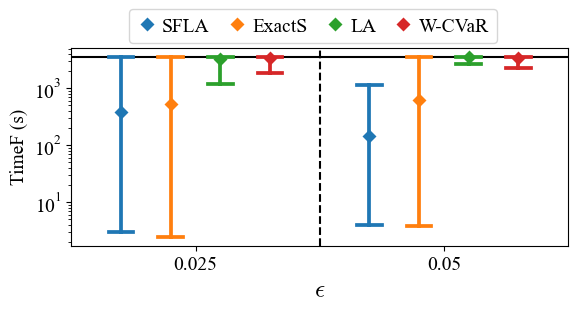

In [15]:
theta = 0.5
epsilon_list_plot = epsilon_list
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# -----------------------------
res_all_methods_all_df_plot = res_all_methods_all_df[(res_all_methods_all_df['theta'] == theta)].copy()
# drop Bonferroni
res_all_methods_all_df_plot_NB = res_all_methods_all_df_plot[res_all_methods_all_df_plot['method'] != 'Bonferroni'].copy()
sns.pointplot(x='eps', y='time F', data=res_all_methods_all_df_plot_NB, ax=ax, 
         hue='method', dodge=.6, estimator='mean', markers=['D', 'D', 'D', 'D'], linestyle='none', errorbar=('pi', 95), zorder=10, capsize = .1, markersize=5)

ax.set_xlabel(r'$\epsilon$', fontsize=18)
ax.set_ylabel('TimeF (s)')
# log y scale
ax.set_yscale('log')
# do not display the legend
ax.get_legend().remove()
    
for line_i in range(0, len(res_all_methods_all_df_plot_NB['eps'].unique())-1):
    ax.axvline(line_i+.5, color='black', linestyle='--')
    
# plot a horizontal line at the timelimit
ax.axhline(timelimit, color='black', linestyle='-')
    
# create my own legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.54, 1.02), ncol=4, columnspacing=0.9, handletextpad=0.3, handlelength=1.)
plt.suptitle('')
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'suc_time_{network_name}_T{T}{"quadra_cost" if quadra_cost else ""}_allmethods_Fgap{Fgap}.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)

/tmp/ipykernel_7334/1684989113.py:11: UserWarning: The palette list has more values (9) than needed (3), which may not be intended.
  sns.stripplot(x='eps', y='Obj. Diff. (%)', data=res_all_methods_all_df_plot_NB, ax=ax, hue = 'method', dodge=True, marker='o', alpha = 0.7, palette=palette)


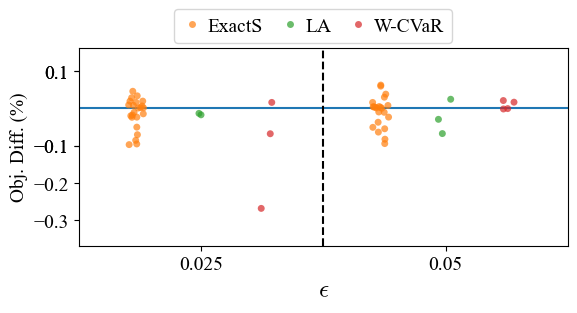

In [16]:
theta = 0.5
epsilon_list_plot = epsilon_list
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
# -----------------------------
res_all_methods_all_df_plot = res_all_methods_all_df[(res_all_methods_all_df['theta'] == theta)].copy()
# drop Bonferroni
res_all_methods_all_df_plot_NB = res_all_methods_all_df_plot[res_all_methods_all_df_plot['method'].isin(['ExactS', 'LA', 'W-CVaR'])].copy()

# start from the second color of the color palette
palette = sns.color_palette('tab10', 10)[1:]
sns.stripplot(x='eps', y='Obj. Diff. (%)', data=res_all_methods_all_df_plot_NB, ax=ax, hue = 'method', dodge=True, marker='o', alpha = 0.7, palette=palette)

# Do not display the legend within the subplot
ax.get_legend().remove()
ax.set_ylabel('Obj. Diff. (%)')
ax.set_xlabel(r'$\epsilon$', fontsize=18)
# draw a horizontal line at 0
ax.axhline(0, color=sns.color_palette("tab10")[0], linestyle='-')
# yticks should at least include 0.1 and -0.1
yticks = ax.get_yticks()
yticks = np.concatenate([yticks, [0.1, -0.1]])
# remove 0
yticks = yticks[yticks != 0]
ax.set_yticks(yticks)
# remove xticks but keep the labels
# set ylim based on the max and min of the data
ax.set_ylim([np.nanmin(res_all_methods_all_df_plot_NB['Obj. Diff. (%)'])-0.1, np.nanmax(res_all_methods_all_df_plot_NB['Obj. Diff. (%)'])+0.1])
    
for line_i in range(0, len(res_all_methods_all_df_plot_NB['eps'].unique())-1):
    ax.axvline(line_i+.5, color='black', linestyle='--')
plt.suptitle('')
# create my own legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.54, 1.02), ncol=4, columnspacing=0.9, handletextpad=0.3, handlelength=1.)
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)
# save the figure
path_name = os.path.join(os.path.dirname(save_path_root), 'figure', f'suc_gap_{network_name}_T{T}{"quadra_cost" if quadra_cost else ""}_allmethods.pdf')
if not os.path.exists(os.path.dirname(path_name)):
    os.makedirs(os.path.dirname(path_name))
plt.savefig(path_name)

In [17]:
# test code to see the progress of the log
log = glt.parse('SUC_results_bigM100000_thread4/case24_ieee_rts_theta0.1_epsilon0.025_gurobi_seed1220000_num_gen100_N_WDR100_load_scaling_factor1_proposed_T20quadra_cost.txt')
log.progress()

,NewSolution,CurrentNode,RemainingNodes,Incumbent,BestBd,Gap,ItPerNode,Time,Depth,Obj,IntInf,LogFilePath,LogNumber,Seed,Version
0,H,0,0.0,523231.523760,30137.726400,0.942000,NaN,0.00,NaN,NaN,NaN,SUC_results_bigM100000_thread4/case24_ieee_rts...,1,0,11.0.3
1,*,0,0.0,523231.523760,30137.726400,0.942000,NaN,0.00,0.0,NaN,NaN,SUC_results_bigM100000_thread4/case24_ieee_rts...,1,0,11.0.3
2,NaN,0,0.0,523231.524000,272138.604000,0.480000,NaN,0.00,0.0,272138.604,628.0,SUC_results_bigM100000_thread4/case24_ieee_rts...,1,0,11.0.3
3,NaN,0,0.0,523231.524000,501597.713000,0.041300,NaN,1.00,0.0,501597.713,216.0,SUC_results_bigM100000_thread4/case24_ieee_rts...,1,0,11.0.3
4,NaN,0,0.0,523231.524000,501748.034000,0.041100,NaN,1.00,0.0,501748.034,33.0,SUC_results_bigM100000_thread4/case24_ieee_rts...,1,0,11.0.3
5,NaN,0,0.0,523231.524000,501750.974000,0.041100,NaN,1.00,0.0,501750.974,26.0,SUC_results_bigM100000_thread4/case24_ieee_rts...,1,0,11.0.3
6,NaN,0,0.0,523231.524000,501750.996000,0.041100,NaN,1.00,0.0,501750.996,26.0,SUC_results_bigM100000_thread4/case24_ieee_rts...,1,0,11.0.3
7,NaN,0,0.0,523231.524000,501750.996000,0.041100,NaN,1.00,0.0,501750.996,51.0,SUC_results_bigM100000_thread4/case24_ieee_rts...,1,0,11.0.3
8,NaN,0,0.0,523231.524000,501751.014000,0.041100,NaN,1.00,0.0,501751.014,51.0,SUC_results_bigM100000_thread4/case24_ieee_rts...,1,0,11.0.3
9,NaN,0,2.0,523231.524000,501751.014000,0.041100,NaN,2.00,0.0,501751.014,51.0,SUC_results_bigM100000_thread4/case24_ieee_rts...,1,0,11.0.3
